# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [21 lines of output]
  + C:\Python313\python.exe C:\Users\l_mal\AppData\Local\Temp\pip-install-49fuwgao\numpy_ade92b7096314651bd4b6bbaaacd5b7f\vendored-meson\meson\meson.py setup C:\Users\l_mal\AppData\Local\Temp\pip-install-49fuwgao\numpy_ade92b7096314651bd4b6bbaaacd5b7f C:\Users\l_mal\AppData\Local\Temp\pip-install-49fuwgao\numpy_ade92b7096314651bd4b6bbaaacd5b7f\.mesonpy-0bax2_k4 -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\l_mal\AppData\Local\Temp\pip-install-49fuwgao\numpy_ade92b7096314651bd4b6bbaaacd5b7f\.mesonpy-0bax2_k4\meson-python-native-file.ini
  The Meson build system
  Version: 1.2.99
  Source dir: C:\Users\l_mal\AppData\Local\Temp\pip-install-49fuwgao\numpy_ade92b7096314651bd4b6bbaaacd5b7f
  Build dir: C:\Users\l_mal\AppData\Local\Temp\pip-install-49fuwgao\numpy_ade92b7096314651bd4b6bbaaacd5b7f\.mesonpy-0bax2_k4
  Bu

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random, logging
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


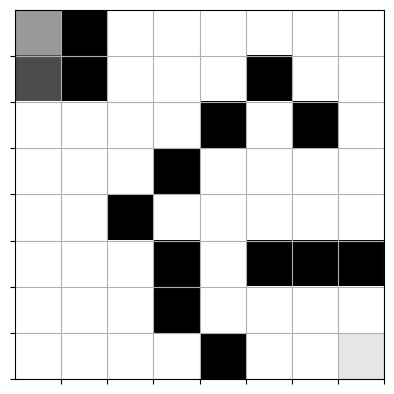

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [10]:
# exploration seed + floor + decay used by qtrain’s internal schedule
epsilon       = 0.25   # start a bit exploratory
epsilon_min   = 0.10   # keep a low but nonzero floor
epsilon_decay = 0.997  # slow decay; bursts will still spike it


In [11]:
def qtrain(model, maze, **opt):
    """
    Adaptive Q-trainer (refined)
    - Tightened MAX_STEPS (120) for less wandering
    - Stronger penalties for loops/timeouts
    - Lower sawtooth exploration frequency/intensity
    - Slightly higher success replay ratio
    """
    import datetime, random
    import numpy as np

    # --- helpers ---
    def _format_time(seconds):
        if seconds < 400:
            return "%.1f seconds" % float(seconds)
        elif seconds < 4000:
            return "%.2f minutes" % (seconds / 60.0)
        else:
            return "%.2f hours" % (seconds / 3600.0)

    def _has_completion_check():
        return 'completion_check' in globals() and callable(globals()['completion_check'])

    # --- core knobs ---
    n_epoch    = opt.get('n_epoch', opt.get('epochs', 15000))
    max_memory = opt.get('max_memory', 4000)
    data_size  = opt.get('data_size', 128)
    min_warmup = max(16, min(128, data_size))
    gamma      = opt.get('gamma', 0.9)


    # cadence — lighter & faster
    MAX_STEPS         = opt.get('max_steps', 110)
    TRAIN_EVERY       = opt.get('train_every', 6)   # was 2 or 4
    UPDATES_PER_TRAIN = opt.get('updates_per_train', 1)  # was 2–3
    EPOCH_END_UPDATES = opt.get('epoch_end_updates', 0)  # was 2–8
    SMALL_DS          = opt.get('small_ds', 32)     # was 48/64
    LARGE_DS          = data_size                  
    data_size         = opt.get('data_size', 96)    # was 128
    WARMUP_SAMPLES    = min(600, max_memory // 2)   # was 800–1000


    # exploration modulation
    PLATEAU_PATIENCE = opt.get('plateau_patience', 20)
    PLATEAU_BUMP     = opt.get('plateau_bump', 0.30)
    BUMP_DURATION    = opt.get('bump_duration', 8)
    best_win_rate    = 0.0
    stagnant_epochs  = 0
    bump_left        = 0

    # sawtooth bursts (periodic mild exploration)
    SAW_PERIOD = opt.get('saw_period', 20)   # less frequent
    SAW_PEAK   = opt.get('saw_peak', 0.28)   # lower ceiling
    SAW_LENGTH = opt.get('saw_length', 2)    # shorter duration
    saw_left   = SAW_LENGTH

    # epsilon globals
    global epsilon
    eps_init      = float(globals().get('epsilon', 1.0))
    epsilon_min   = float(globals().get('epsilon_min', 0.15))
    epsilon_decay = float(globals().get('epsilon_decay', 0.995))
    eps = eps_init if eps_init > epsilon_min else SAW_PEAK

    # success replay
    success_buffer = []
    MAX_SUCCESS    = opt.get('max_success_buf', 512)

    # quiet keras logs
    start_time = datetime.datetime.now()
    try:
        from keras.utils import disable_interactive_logging
        disable_interactive_logging()
    except Exception:
        try:
            import tensorflow as tf
            tf.keras.utils.disable_interactive_logging()
        except Exception:
            pass

    # env + replay
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)

    def exp_len():
        try:
            return len(experience)
        except TypeError:
            buf = getattr(experience, "memory", getattr(experience, "buffer", []))
            return len(buf)

    win_history = []
    hsize = min(50, max(20, qmaze.maze.size // 2))
    win_rate = 0.0

    for epoch in range(n_epoch):
        game_over = False
        loss = 0.0

        actions = qmaze.valid_actions()
        Agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(Agent_cell)
        envstate = qmaze.observe()

        visited_states = set([tuple(np.asarray(envstate).ravel())])
        _current_traj = []

        steps = 0
        rand_val = 0.0  # monitor ε randomness

        while not game_over and steps < MAX_STEPS:
            steps += 1
            previous_envstate = envstate

            # ε-greedy policy
            rand_val = np.random.rand()
            if rand_val < eps:
                action = random.choice(actions)
            else:
                q_values = model.predict(previous_envstate.reshape(1, -1), verbose=0)
                action = int(np.argmax(q_values[0]))

            envstate, reward, game_status = qmaze.act(action)
            envstate = qmaze.observe()

            # --- reward shaping ---
            reward -= 0.0125  # stronger step penalty
            st_key = tuple(np.asarray(envstate).ravel())
            if st_key in visited_states:
                reward -= 0.08   # stronger revisit penalty
            else:
                visited_states.add(st_key)

            game_over = (game_status != 'not_over')

            transition = [previous_envstate, action, reward, envstate, game_over]
            experience.remember(transition)
            _current_traj.append(transition)

            if exp_len() >= min_warmup and ((steps % TRAIN_EVERY) == 0 or game_over):
                ds = SMALL_DS if exp_len() < WARMUP_SAMPLES else LARGE_DS
                inputs, targets = experience.get_data(ds)

                if success_buffer:
                    k = max(1, ds // 8)  # of batch from success buffer
                    pick = random.sample(success_buffer, min(k, len(success_buffer)))
                    s_inputs, s_targets = [], []
                    for s_prev, s_act, s_rew, s_next, s_done in pick:
                        q_prev = model.predict(s_prev.reshape(1, -1), verbose=0)[0]
                        if s_done:
                            q_prev[s_act] = s_rew
                        else:
                            q_next = model.predict(s_next.reshape(1, -1), verbose=0)[0]
                            env_gamma = getattr(qmaze, "gamma", gamma)
                            q_prev[s_act] = s_rew + env_gamma * np.max(q_next)
                        s_inputs.append(s_prev.reshape(1, -1))
                        s_targets.append(q_prev.reshape(1, -1))
                    if s_inputs:
                        inputs  = np.vstack([inputs,  np.vstack(s_inputs)])
                        targets = np.vstack([targets, np.vstack(s_targets)])

                for _ in range(UPDATES_PER_TRAIN):
                    loss += model.train_on_batch(inputs, targets)

        # timeout handling
        if (steps >= MAX_STEPS) and (game_status == 'not_over'):
            experience.remember([previous_envstate, action, -0.7, envstate, True])  # stronger penalty
            if exp_len() >= min_warmup:
                ds = SMALL_DS if exp_len() < WARMUP_SAMPLES else LARGE_DS
                inputs, targets = experience.get_data(ds)
                loss += model.train_on_batch(inputs, targets)
            game_status = 'lose'
            game_over = True

        if exp_len() >= min_warmup:
            for _ in range(EPOCH_END_UPDATES):
                ds = SMALL_DS if exp_len() < WARMUP_SAMPLES else LARGE_DS
                inputs, targets = experience.get_data(ds)
                loss += model.train_on_batch(inputs, targets)

        # cache success steps
        if game_status == 'win' and _current_traj:
            success_buffer.extend(_current_traj[-32:])
            if len(success_buffer) > MAX_SUCCESS:
                success_buffer = success_buffer[-MAX_SUCCESS:]

        # record progress
        win_history.append(1 if game_status == 'win' else 0)
        recent = win_history[-hsize:] if len(win_history) >= hsize else []
        win_rate = (sum(recent) / float(hsize)) if recent else 0.0

        # --- ε decay logic ---
        eps = max(epsilon_min, eps * epsilon_decay)

        # sawtooth periodic bursts
        if ((epoch + 1) % SAW_PERIOD) == 0:
            saw_left = SAW_LENGTH
        if saw_left > 0:
            eps = max(eps, SAW_PEAK)
            saw_left -= 1

        # plateau bump
        if win_rate > best_win_rate + 1e-6:
            best_win_rate = win_rate
            stagnant_epochs = 0
        else:
            stagnant_epochs += 1
            if stagnant_epochs >= PLATEAU_PATIENCE:
                bump_left = BUMP_DURATION
                stagnant_epochs = 0
        if bump_left > 0:
            eps = max(eps, PLATEAU_BUMP)
            bump_left -= 1

        # expose updated epsilon to global
        epsilon = eps
        
        # Memory warning
        if (epoch + 1) % 100 == 0:
            print(f"Memory used: {len(experience.memory)}/{max_memory}")

        # log progress
        dt = datetime.datetime.now() - start_time
        print(
            f"Epoch: {epoch+1:03d}/{n_epoch} | Loss: {loss:.4f} | Steps: {steps:d} "
            f"| Wins: {sum(win_history):d} | Win rate: {win_rate:.3f} | eps: {eps:.3f} "
            f"| rand:{rand_val:.2f} | bump_left:{bump_left} saw_left:{saw_left} | time: {_format_time(dt.total_seconds())}",
            flush=True
        )

        # early-exit conditions
        if win_rate > 0.9:
            eps = 0.05
            epsilon = eps
        if len(recent) == hsize and sum(recent) == hsize and _has_completion_check():
            if completion_check(model, qmaze):
                print(f"Reached 100% win rate at epoch: {epoch+1}")
                break

    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" %
          (epoch+1, max_memory, data_size, _format_time(seconds)))
    return seconds



## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

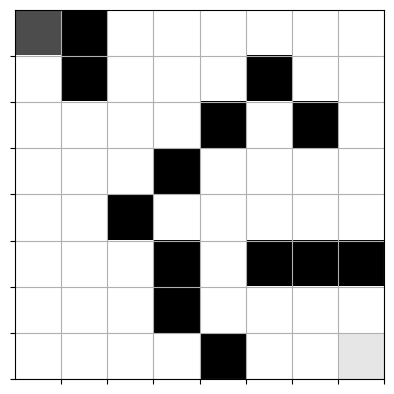

In [12]:
qmaze = TreasureMaze(maze)
show(qmaze)

In [13]:
def randomly_select_free_cell(qmaze):
    # Find all free (non-wall) cells in the maze
    free_cells = [(r, c) for r in range(qmaze.rows)
                         for c in range(qmaze.cols)
                         if qmaze.maze[r, c] == 0]  # assuming 0 means free
    return random.choice(free_cells)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [14]:
model = build_model(maze)
qtrain(model, maze, epochs=1500, max_memory=8*maze.size, data_size=32)

C:\Users\l_mal\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 001/1500 | Loss: 0.2140 | Steps: 110 | Wins: 0 | Win rate: 0.000 | eps: 0.280 | rand:0.77 | bump_left:0 saw_left:1 | time: 40.6 seconds
Epoch: 002/1500 | Loss: 0.2242 | Steps: 110 | Wins: 0 | Win rate: 0.000 | eps: 0.280 | rand:0.59 | bump_left:0 saw_left:0 | time: 94.2 seconds
Epoch: 003/1500 | Loss: 0.2290 | Steps: 110 | Wins: 0 | Win rate: 0.000 | eps: 0.279 | rand:0.27 | bump_left:0 saw_left:0 | time: 146.6 seconds
Epoch: 004/1500 | Loss: 0.0663 | Steps: 30 | Wins: 1 | Win rate: 0.000 | eps: 0.278 | rand:0.12 | bump_left:0 saw_left:0 | time: 161.2 seconds
Epoch: 005/1500 | Loss: 0.4069 | Steps: 110 | Wins: 1 | Win rate: 0.000 | eps: 0.277 | rand:0.59 | bump_left:0 saw_left:0 | time: 220.4 seconds
Epoch: 006/1500 | Loss: 0.4482 | Steps: 110 | Wins: 1 | Win rate: 0.000 | eps: 0.277 | rand:0.32 | bump_left:0 saw_left:0 | time: 279.0 seconds
Epoch: 007/1500 | Loss: 0.4781 | Steps: 110 | Wins: 1 | Win rate: 0.000 | eps: 0.276 | rand:0.88 | bump_left:0 saw_left:0 | time: 340.8 sec

73567.196165

In [26]:
for _ in range(3):
    q = model.predict(qmaze.observe(), verbose=0)[0]
    print(np.round(q, 3))

[-4.358 -4.359 -4.681 -4.408]
[-4.358 -4.359 -4.681 -4.408]
[-4.358 -4.359 -4.681 -4.408]


This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [23]:
# --- 1) Patch update_state on THIS qmaze instance ---
from types import MethodType

def patched_update_state(self, action):
    nrows, ncols = self.maze.shape
    pirate_row, pirate_col, mode = self.state
    nrow, ncol = pirate_row, pirate_col
    nmode = mode

    if self.maze[pirate_row, pirate_col] > 0.0:
        self.visited.add((pirate_row, pirate_col))

    valid_actions = self.valid_actions()
    if not valid_actions:
        nmode = 'blocked'
    elif action in valid_actions:
        nmode = 'valid'
        if action == 0:   # LEFT
            ncol -= 1
        elif action == 1: # UP
            nrow -= 1
        elif action == 2: # RIGHT
            ncol += 1
        elif action == 3: # DOWN
            nrow += 1
    else:
        nmode = 'invalid'

    self.state = (nrow, ncol, nmode)

qmaze.update_state = MethodType(patched_update_state, qmaze)
print("✅ update_state patched on qmaze")


✅ update_state patched on qmaze


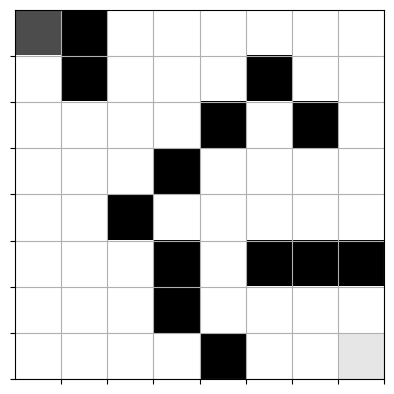

In [24]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

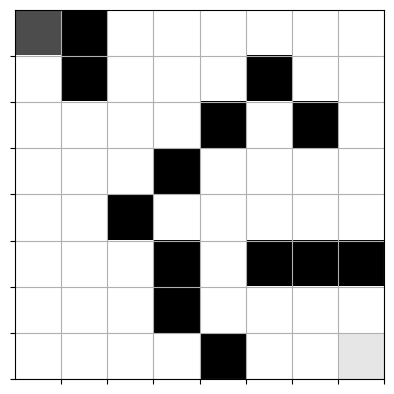

In [25]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.